# Numerical Methods - QF 607 Group Project
## Group member: GOURAV KUMAR AGARWAL and ANIRUDH KRISHNAN

### ABSTRACT

In this project, we have worked on implementing an arbitrage free smile interpolator following Fengler's (2009) work. We then used this AF IV to construct a local vol to used it with a PDE to price an European Put option for various strike and maturity.

We have then compared the pricing errors using this arbitrage free vol surface with that from the normal vol surface built using cubic spline. In addition, we have also shown how the comparison after using Black scholes price from cubic spline IV as baseline in both cases.

In the 3rd section, we also verified the results using various methods. We have first checked for call price smoothness. Then we also did the PDF surface plot to check for negative PDFs. We then went on to inspect a time slice of vol surface to check if the Marks exactly fall on the fitten vol. We then also checked a time slice of a call price to verify that it is monotonically decreasing.

In the 4th section, we did some critical analysis of the implementation and pointed out some issues we observed including how we think marks could be made to fit better by optimising the strike grid we are using and how tails can be fit better to a particular shape for more accurate vol surface.

In the 5th section, we suggested and implemented some improvements to remediate the issues we found in section 4. We were able improve the fitted vol smile further. We were able to model the tail which reduced the price errors and we were also able to increase efficiency of the PDE Calibration Report generation by vectorization and thus reducing the time taken from about 64 seconds to 12.5 seconds.

If you want to skip the main code, you can straight away [Jump to Project Report](#project-report) at the end of this notebook from here. Or, you can click on any of the sections of the Report linked below to direct yourself to the respective sections.

- [Section 1. Notes on the result](#section-1)
- [Section 2. Comparison of Pricing Errors](#section-2)
- [Section 3. Verification of the Results](#section-3)
- [Section 4. Critical Analysis and Issues](#section-4)
- [Section 5. Improvements made](#section-5)
- [Section 6. Conclusion and Next Steps](#section-6)

# Course Project: An Arbitrage-Free Smile Interpolator
*Project report should be submitted as a Jupyter notebook (.ipynb). Each project group should have 1 to 3 members. The report should be written based on this notebook. Please make your formulas and code, test results, observations, intermediate results, improvements made/suggested (optional), and conclusions clear.*

#### Objectives
  - Implement an arbitrage free smile interpolator SmileAF.
  - Use the arbitrage free smile interpolator to construct local volatility model
  - Use PDE with local volatility model to price a given set of European options (strike in delta $\times$ maturity)
  - Compare the price errors of arbitrage-free smile interpolator and the cubic spline smile interpolator
  - Open questions for bonus points: improve the algorithms in terms of precision and efficiency (smile interpolation, implied vol, local vol, PDE, calibration report). One area to consider for improvement is the construction of the tails (wings).

##### Smile Arbitrage
1. European call prices are monotonically decreasing with respect to the strike:

    \begin{align}
    C(S_0, K_1, T, \sigma(K_1), r, q) \geq C(S_0, K_2, T, \sigma(K_2), r, q) ~\text{for}~K_1 < K_2
    \end{align}


2. The European call price as a function of strike has to be convex every where: for any three points $K_1 < K_2 < K_3$

    \begin{align*}
    \frac{C(K_2) - C(K_1) } {K_2 - K_1} < \frac{C(K_3) - C(K_2) } {K_3 - K_2}
    \end{align*}

    or

    \begin{align}
    C(K_2)  < C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1}  \tag{2}
    \end{align}

    This is also equivalent to "butterfly price has to be non-negative".

##### When Could Smile Arbitrage Happen?

The undiscounted call price is the expectation of payoff under risk neutral measure

\begin{align*}
C(K) = E[\max(S-K, 0)]
\end{align*}

And expectation is an integral over the probability density function $p(s)$

\begin{align*}
C(K) = \int_{K}^{+\infty} (s-K) p(s) ds
\end{align*}

The 1st non-arbitrage condition translates to

\begin{align*}
& C(K_1) - C(K_2) = \left[ \int_{K_1}^{K_2} (s-K_1) p(s) ds  + \int_{K_2}^{+\infty} (K_2-K_1) p(s) ds \right]
\end{align*}

which is positive by definition if $K_2 > K_1$.

The 2nd non-arbitrage condition translates to

\begin{align*}
& C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1} - C(K_2) \\
= & \frac{K_3-K_2} {K_3 - K_1} \int_{K_1}^{K_2} (s-K_1) p(s) ds + \frac{K_2 - K_1} {K_3 - K_1} \int_{K_2}^{K_3} (K_3 - s) p(s) ds
\end{align*}

which is also positive by definition if $K_3 > K_2 > K_1$.

So, when could smile arbitrage happen? **When the probability density does not exist**. If we can start with valid probability density function $p(s)$, arbitrage-freeness is guaranteed by construction.


#### Arbitrage Free Smile (Based on [Fengler 2009])

- We consider smile construction for a given expiry $T$.
- Start with $N$ discrete sample strike points

    \begin{align*}
    \vec{k} = [k_1, k_2, \ldots, k_{N}]^{\top}
    \end{align*}

- Try to solve for undiscounted call prices for these $N$ sample points

    \begin{align*}
    \vec{c} = [c_1, c_2, \ldots, c_N]^{\top}
    \end{align*}

- For the undiscounted call price $C(K)$ for any $K$, we can interpolate using cubic spline over the sample points $(k_i, c_i)$. (Note that we are using cubic spline to interpolate the prices, not volatility)

- The second derivative of call price with respect to strike is the probability density function:

\begin{align*}
    \frac{d C}{d K} & =  d \frac{\int_K^{\infty} Sp(S) dS}{dK} - d \frac{K\int_K^{\infty} p(S) dS}{dK} = -Kp(K) - \left( \int_K^{\infty} p(S) dS - K p(K)\right) = -\int_K^{\infty} p(S) dS \\
    \frac{d^2 C}{d K^2} & = p(K)
\end{align*}

  So $c_i''$ is probability density function at $k_i$, we denote it as $p_i$

- Second derivatives in cubic spline interpolation form line segments. Cubic spline on $C(K)$, means linearly interpolate on probability density. If $p_i$ are all positive, the whole pdf is positive by construction --- **no smile arbitrage**.

- For tails --- call prices are almost linear if strike is very far away from spot, we can use **natural cubic spline**: $p_1 = p_N = 0$.

- Our problem is to solve for $[c_1, c_2, \ldots, c_{N}, p_2, \ldots, p_{N-1}]$

#### Inputs to our problem

Same as our Cubic Spline smile interpolator, we have the input marks to start with to construct the Arb-Free(AF) smile interpolator:

 - **Marks**:  strike to volatility pairs, denote as $(\hat k_j, \sigma_j)$, for $j \in [1, 2, \ldots, M]$. In our case, $M=5$.

We would like to match the marks exactly. And we cannot directly construct a cubic spline using the $M$ points --- too coarse and distribution is not realistic.

#### Problem Definition
- We use $N = 50$ sample points, ranging from $[k_1 = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T - 5 \sigma_{ATM} \sqrt{T}}, k_N = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T + 5 \sigma_{ATM} \sqrt{T} }]$, i.e., $\pm 5$ standard deviation based on $\sigma_{ATM}$.
- $\sigma_{ATM}$ is implied volatility of the middle point of the input marks.
- We also assume the strike of the middle point of the input marks is the forward --- ATM forward convention.
- The sample points are equally spaced, denote the length of the segment $u = \frac{k_N - k_1}{N-1}$
- We would like the call prices to be as smooth as possible --- minimize the change of the slopes
- We want to match exactly the $M$ input marks.
- This is a constrained optimization problem.

 **Constraints**
 - Cubic spline interpolation imposes the constraints that the left and right first derivative of a point have to match, it can be derived by matching the first  derivative of the left and right segments for point $i$ we have the condition

\begin{align*}
   c_{i+1} + c_{i-1} - 2 c_{i} = (\frac23 p_i + \frac16 p_{i+1} + \frac16 p_{i-1}) u^2
\end{align*}

   The cubic spline constraints translate to the linear system

\begin{align*} 
\underbrace{\begin{pmatrix}
   1 & -2 & 1 & 0 & \ldots & 0 \\
   0 & 1 & -2 & 1 & \ddots & \vdots \\
   \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
   0 & \ldots & 0 & 1 & -2 & 1
   \end{pmatrix}}_{\vec{Q}_{(N-2) \times N}}
   \begin{pmatrix}
   c_1 \\
   c_2 \\
   \vdots \\
   c_N
   \end{pmatrix} =
   \underbrace{u^2
   \begin{pmatrix}
   \frac23 & \frac16 & 0 & \ldots & 0 \\
   \frac16 & \frac23 & \frac16 & \ddots & \vdots \\
   0 & \ddots & \ddots & \ddots & 0 \\
   \vdots & \ddots & \frac 1 6 & \frac23 & \frac16 \\
   0 & \ldots & 0 & \frac 1 6 &  \frac23
   \end{pmatrix}}_{\vec{R}_{(N-2) \times (N-2)}}
   \begin{pmatrix}
   p_2 \\
   p_3 \\
   \vdots \\
   p_{N-1}
   \end{pmatrix}
\end{align*}

   If we define
\begin{align*}
   \vec{x} =
   \begin{pmatrix}
   \vec{c}^{\top} \\
   \vec{p}^{\top} \\
   \end{pmatrix}, ~~~
   \vec{A} = (\vec{Q}, -\vec{R})
\end{align*}

   we can represent the constraint as:
\begin{align*}
   \vec{Ax} = \vec{0}        ~~~\textbf{--- Constraint 1}
\end{align*}

 - The call prices at the input marks $\hat k_j, j \in [1, 2, \ldots, M]$ can be represented by cubic spline interpolation
\begin{align*}
   C(\hat k_j) =  a c_i + b c_{i+1} + \frac{(a^3 - a)u^2}6 p_i + \frac{(b^3-b) u^2}6 p_{i+1}   ~~~\textbf{--- Constraint 2}
\end{align*}

   where

\begin{align*}
   a = \frac{k_{i+1} - \hat k_j}{u},~~~b = 1-a
\end{align*}

   and $[k_i, k_{i+1}]$ here represents the segment that $\hat k_j$ falls in.

 - $p_i$ are densities, so

\begin{align*}
    p_i > 0 ~~~\textbf{--- Constraint 3}
\end{align*}

 - Integrating the density function we should get 1.0 (recall that density function are linearly interpolated)

\begin{align*}
    u \sum p_i = 1.0 ~~~\textbf{--- Constraint 4}
\end{align*}

 - Natural cubic spline, $p_1$ and $p_N$ are zero, so we could solve directly $c_1$ and $c_N$

    \begin{align*}
    c_1 = Se^{(r_d - r_f)T} - k_1, ~~~c_N = 0  ~~~\textbf{--- Constraint 5}
    \end{align*}

 - Call prices are monotonically decreasing:

    \begin{align*}
    c_{i+1} - c_{i} \leq 0 ~~~\text{for}~i \in \{1, 2, \ldots, N-1\}  ~~~\textbf{--- Constraint 6}
    \end{align*}


 **Objective Function**

 - Fill the rest of the DOF using objective function (soft constraints)

 - [Fengler 2009] tried minimizing the below to achieve smoothness on $p$:

    \begin{align*}
    \int_{k_1}^{k_N} p(S)^2 dS = \text{constant} \times \vec{p}^{\top} \vec{R} \vec{p}
    \end{align*}

    Using $\vec{x}$ as variable and define

    \begin{align*}
    \vec{H}_{(2N-2) \times (2N-2)} =
    \begin{pmatrix}
    \vec{0} & \vec{0} \\
    \vec{0} & \vec{R}_{(N-2) \times (N-2)}
    \end{pmatrix}
    \end{align*}

    the problem becomes minimizing

    \begin{align*}
    \vec{x}^\top \vec{H} \vec{x}
    \end{align*}

**Problem Formulation**

We can formulate our problem as
\begin{align*}
    \min~~~\vec{x}^\top \vec{H} \vec{x}
\end{align*}
 subject to constraints 1 to 5.
 - All the constraints are linear function of $\vec{x}$
 - Our objective function is quadratic and the matrix $\vec{H}$ is positive semi-definite
 - Global solution exists, and (relatively) efficient to solve

**Tips**
 - To solve the quadratic programming problem, we can use the CVXOPT package:
   - http://cvxopt.org/examples/tutorial/qp.html
   - https://buildmedia.readthedocs.org/media/pdf/cvxopt/dev/cvxopt.pdf
 - Write down the exact formulas using the same symbols used by CVXOPT QP problem's documentation in the above docs, then translate them into code. This will make debugging easier.
 - To check whether solver's result makes sense, examine if the constraints are satisified, and if the call prices are smooth and match the input.
 - If test run takes too long, reduce the number of grid points in PDE pricer, or skip the calibration report and inspect the volatility surface first.
 - It might be easier to plot implied vol, call prices, PDF, and the marks to check the result.
 - use bisect.bisect_left to find the bucket $\hat{k}$ belongs to (https://docs.python.org/3/library/bisect.html)

**References**

[Fengler 2009] Arbitrage-free smoothing of the implied volatility surface, Quantitative Finance, 2009

***
### Implementation

Below are some building blocks for the project. You contribution should be in SmileAF class.
You can modify any other classes or methods. If you do so, please describe your modification in the project report.

In [1]:
import math
from enum import Enum
from scipy import optimize
import bisect
from scipy.interpolate import CubicSpline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

class PayoffType(Enum):
    Call = 0
    Put = 1

def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return - cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

# solve for the K such that Delta(S, T, K, vol) = delta
def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    fwd = S * math.exp((r-q) * T)
    if payoffType == PayoffType.Put:
        delta = -delta
    f = lambda K: (fwdDelta(fwd, vol * math.sqrt(T), K, payoffType) - delta)
    a, b = 0.0001, 10000
    return optimize.brentq(f, a, b)

class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return

    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.001) - self.Vol(t, k-0.001)) / 0.002
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.001) + self.Vol(t, k-0.001) - 2*self.Vol(t, k)) / 0.000001

class LocalVol:
    def __init__(self, iv, S0, rd, rf):
        self.iv = iv
        self.S0 = S0
        self.rd = rd
        self.rf = rf
    def LV(self, t, s):
        if t < 1e-6:
            return self.iv.Vol(t, s)
        imp = self.iv.Vol(t, s)
        dvdk = self.iv.dVoldK(t, s)
        dvdt = self.iv.dVoldT(t, s)
        d2vdk2 = self.iv.dVol2dK2(t, s)
        d1 = (math.log(self.S0/s) + (self.rd-self.rf)*t + imp * imp * t / 2) / imp / math.sqrt(t)
        numerator = imp*imp + 2*t*imp*dvdt + 2*(self.rd-self.rf)*s*t*imp*dvdk
        denominator = (1+s*d1*math.sqrt(t)*dvdk)**2 + s*s*t*imp*(d2vdk2 - d1 * math.sqrt(t) * dvdk * dvdk)
        localvar = min(max(numerator / denominator, 1e-8), 1.0)
        if numerator < 0: # floor local volatility
            localvar = 1e-8
        if denominator < 0: # cap local volatility
            localvar = 1.0
        return math.sqrt(localvar)

class EuropeanOption():
    def __init__(self, assetName, expiry, strike, payoffType):
        self.assetName = assetName
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

# Black-Scholes analytic pricer
def bsPrice(S, r, q, vol, T, strike, payoffType):
    fwd = S * math.exp((r-q) * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    else:
        raise Exception("not supported payoff type", payoffType)

# PDE pricer with local volatility
def pdePricerX(S0, r, q, lv, NX, NT, w, trade):
    # set up pde grid
    mu = r - q
    T = trade.expiry
    X0 = math.log(S0)
    vol0 = lv.LV(0, S0)
    srange = 5 * vol0 * math.sqrt(T)
    maxX = X0 + (mu - vol0 * vol0 * 0.5)*T + srange
    minX = X0 - (mu - vol0 * vol0 * 0.5)*T - srange
    dt = T / (NT-1)
    dx = (maxX - minX) / (NX-1)
    # set up spot grid
    xGrid = np.array([minX + i*dx for i in range(NX)])
    # initialize the payoff
    ps = np.array([trade.payoff(math.exp(x)) for x in xGrid])
    # backward induction
    for j in range(1, NT):
        # set up the matrix, for LV we need to update it for each iteration
        M = np.zeros((NX, NX))
        D = np.zeros((NX, NX))
        for i in range(1, NX - 1):
            vol = lv.LV(j*dt, math.exp(xGrid[i]))
            M[i, i - 1] = (mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            M[i, i] = r + vol * vol / dx / dx
            M[i, i + 1] = -(mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            D[i, i] = 1.0
        # the first row and last row depends on the boundary condition
        M[0, 0], M[NX - 1, NX - 1] = 1.0, 1.0
        rhsM = (D - dt * M) * w + (1 - w) * np.identity(NX)
        lhsM = w * np.identity(NX) + (D + dt * M) * (1 - w)
        inv = np.linalg.inv(lhsM)

        ps = rhsM.dot(ps)
        ps[0] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[0])) # discounted payoff
        ps[NX-1] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[NX-1]))
        ps = inv.dot(ps)
    # linear interpolate the price at S0
    return np.interp(X0, xGrid, ps)

Below are the smile interpolators and smile constructor. You need to implement SmileAF. Note that smileFromMarks takes a parameter smileInterpMethod. When it is 'AF', SmileAF is used.

In [2]:
from cvxopt import matrix, solvers

class SmileAF:
    def __init__(self, strikes, vols, T):
        self.atmvol = vols[int(len(vols)/2)]
        self.fwd = strikes[int(len(strikes)/2)]
        self.T = T
        self.N = 50  ## Set to 51 to test improbvement mentioned in section 5.1 of the Report
        self.strikemarks=strikes
        self.volmarks=vols
        stdev = self.atmvol * math.sqrt(T)

        ## Setting Spread of the Strike Grid using normal method
        kmin = self.fwd * math.exp(-0.5*stdev*stdev-5 * stdev)
        kmax = self.fwd * math.exp(-0.5*stdev*stdev+5 * stdev)

        ## Setting Spread of the Strike Grid in linear fasion ## used to test improvement mentioned in section 5.1 (1) of the Report
        # kmin = self.fwd - (5*stdev)
        # kmax = self.fwd + (5*stdev)

        u = (kmax - kmin) / (self.N - 1)
        self.ks = [kmin + u * i for i in range(0, self.N)]

        ## The below section is to test improvement mentioned in section 5.1 (2)
        ## Optimize Ks by minimizing sum of square distance between marks and naive strike grid ## 
        # def ks_ssr(delta):
        #     res = 0
        #     for i in strikes:
        #         s=0
        #         for j in self.ks:
        #             s = s + (j+delta-i)**2
        #         if i == strikes[int(len(strikes)/2)]:
        #             print("entering atm strike")
        #             res = res + 4*s    ## To give 4 times weight to atm strike
        #         else:
        #             print("not entering atm strike")
        #             res = res + s
        #     return res
        #
        # result = optimize.minimize(ks_ssr,u, method='L-BFGS-B')
        #
        # self.ks = [i + result.x[0] for i in self.ks]


        self.cs = np.zeros(self.N)  # undiscounted call option prices
        self.ps = np.zeros(self.N)  # densities
        self.u = u
        # now we need to construct our constrained optimization problem to solve for cs and ps
        # ... YOUR CODE HERE ... to solve for self.cs and self.ps
        # ...

        ## Objective Function

        ## Define R

        # print(f'strike: {strikes}')
        # print(f'vols: {vols}')
        # print(f'u: {u}')
        # print(f'ks={self.ks}')
        # print(f'T={T}')
        # print(f'fwd={self.fwd}')

        R_v = np.zeros((self.N -2 , self.N -2 ))
        R_v[0,0]=2/3
        R_v[0,1]=1/6
        for i in range(1,self.N - 3):
            R_v[i,i-1]=1/6
            R_v[i,i]=2/3
            R_v[i,i+1]=1/6
        R_v[self.N-3,self.N-4]=1/6
        R_v[self.N-3,self.N-3]=2/3
        R_v= self.u * self.u * R_v
        #print(R_v.shape)
        #print(f'R_v: {R_v}')

        ## Define H
        H_v = np.zeros((2*self.N -2 , 2*self.N -2 ))
        # for i in range(0,self.N): ## temporarily setting diagnol terms to non-zero to make the matrix invertible
        #     H_v[i,i] =  0.000005
        H_v[self.N:,self.N:] = R_v
        #print(H_v.shape)
        #print(f'HH: {H_v}')

        ### Constraint 1
        
        ## Define Q
        Q_v = np.zeros((self.N -2 , self.N ))
        for i in range(0,self.N - 2):
            Q_v[i,i]     = 1
            Q_v[i,i+1]   = -2
            Q_v[i,i+2]   = 1

        #print(f'Q_vv: {Q_v}')

        ## Define A
        A1_v = np.concatenate((Q_v, -R_v), axis=1)
        b1_v = np.zeros((self.N -2 , 1))

        #print(A1_v)


        ### Constraint 2

        def striketoprice(j):
            k= strikes[j]
            v = vols[j]
            stdev = v * math.sqrt(self.T)
            d1 = (math.log(self.fwd / k)) / stdev + 0.5 * stdev
            d2 = (math.log(self.fwd / k)) / stdev - 0.5 * stdev
            return self.fwd * cnorm(d1) - k * cnorm(d2)
        

        A2_v = np.zeros((len(strikes),2*self.N - 2))
        b2_v = np.zeros((len(strikes), 1))

        for j in range(0,len(strikes)):
            i = bisect.bisect_left(self.ks, strikes[j]) - 1
            k_j = strikes[j]
            k_i_1= self.ks[i+1]
            a=(k_i_1-k_j)/self.u
            b=1-a
            A2_v[j,i] = a
            A2_v[j,i+1] = b
            A2_v[j,self.N -1 + i] = ((a*a*a)-a)*self.u*self.u/6
            A2_v[j,self.N + i] = ((b*b*b)-b)*self.u*self.u/6
            b2_v[j,0] = striketoprice(j)

        ### Constraint 3

        G3_v = np.zeros((self.N -2 , 2*self.N - 2 ))
        for i in range(0,self.N -2):
            G3_v[i,i+self.N] = -1
        
        h3_v = np.zeros((self.N -2,1))


        ### Constraint 4

        A4_v = np.zeros((1,2*self.N - 2))
        for i in range(self.N,2*self.N -2):
            A4_v[0,i]=self.u

        b4_v = np.zeros((1 , 1))
        b4_v[0,0]=1

        ### Constraint 5
        
        A5_v = np.zeros((2,2*self.N - 2))
        A5_v[0,0]=1
        A5_v[1,self.N -1]=1

        b5_v = np.zeros((2 , 1))
        b5_v[0,0] = self.fwd - self.ks[0]
        b5_v[1,0] = 0

        ### Constraint 6

        G6_v = np.zeros((self.N -1 , 2*self.N - 2 ))
        for i in range(0,self.N -1):
            G6_v[i,i] = -1
            G6_v[i,i+1] = 1
        
        h6_v = np.zeros((self.N -1,1))

        ## Optimization

        Q = matrix(2 * H_v)
        p = matrix(np.zeros(2*self.N -2)) ##np.zeros((2*self.N -2 , 1))
        G = matrix(np.concatenate((G3_v, G6_v), axis=0))
        h = matrix(np.concatenate((h3_v, h6_v), axis=0))
        A = matrix(np.concatenate((A1_v, A2_v, A4_v, A5_v), axis=0))
        b = matrix(np.concatenate((b1_v, b2_v, b4_v, b5_v), axis=0))

        #test
        #sol = solvers.qp(Q, p, G, h)
        sol = solvers.qp(Q, p, G, h, A, b)
      

        # H = np.random.rand(self.N, self.N)
        # P = H  # Quadratic term in the objective function
        # q = matrix(0.0, (self.N, 1))  # Linear term in the objective function
        # G = matrix(0.0, (self.N, self.N))  # No inequality constraints
        # h = matrix(0.0, (self.N, 1))  # No inequality constraints

        # # Solve the QP to minimize the objective function
        # sol = solvers.qp(P, q, G, h)

        # Extract the optimal solution
        optimal_solution = sol['x']
        # print(f'Optimal_solution: {optimal_solution}')
        
        # print('Optimization Done')

        optimal_solution_array = np.array(optimal_solution).T.flatten()
        self.cs = optimal_solution_array[0:self.N]
        self.ps[1:self.N -1] = optimal_solution_array[self.N:]

        # print(f'cs = {self.cs}')
        # print(f'ps = {self.ps}')


        # print(f'cs: {self.cs}')
        # print(f'ps: {self.ps}')
        #print(f'ks: {self.ks}')
        #print(f'fwd: {self.fwd}')
        #print(f'Strikes: {strikes}')

        # now we obtained cs and ps, we do not interpolate for price for any k and imply the vol,
        # since at the tails the price to vol gradient is too low and is numerically not stable.
        # Instead, we imply the volatilities for all points between put 10 delta and call 10 delta input points
        # then we make the vol flat at the wings by setting the vols at kmin and kmax,
        # we then construct a cubic spline interpolator on the dense set of volatilities so that it's C2
        # and faster then implying volatilities on the fly.
        # note that this treatment of tail is simplified. It could also introduce arbitrage.
        # In practice, the tails should be calibrated to a certain distribution.
        def implyVol(k, prc, v):
            stdev = v * math.sqrt(self.T)
            d1 = (math.log(self.fwd / k)) / stdev + 0.5 * stdev
            d2 = (math.log(self.fwd / k)) / stdev - 0.5 * stdev
            return self.fwd * cnorm(d1) - k * cnorm(d2) - prc
        khmin = bisect.bisect_left(self.ks, strikes[0])
        khmax = bisect.bisect_right(self.ks, strikes[len(strikes)-1])

        ## Original Code with boundary of the wings set to same value and left to be interpolated using cubic smile
        kks = [0] * ((khmax+1) - (khmin-1) + 2)
        vs = [0] * ((khmax+1) - (khmin-1) + 2)
        for i in range(khmin-1, khmax+1):
            prc = self.Price(self.ks[i])
            #print(f'i: {i}, prc: {prc}')
            f = lambda v: implyVol(self.ks[i], prc, v)
            a, b = 1e-8, 10
            vs[i - (khmin-1) + 1] = optimize.brentq(f, a, b)
            kks[i - (khmin-1) + 1] = self.ks[i]
        kks[0] = kmin
        vs[0] = vs[1]
        kks[len(kks)-1] = kmax
        vs[len(vs)-1] = vs[len(vs)-2]
        self.kks=kks

        # flat vol at wings
        # kks = [0] * ((khmax+1) - (khmin-1))
        # vs = [0] * ((khmax+1) - (khmin-1))
        # for i in range(khmin-1, khmax+1):
        #     prc = self.Price(self.ks[i])
        #     # print(f'i: {i}, prc: {prc}')
        #     f = lambda v: implyVol(self.ks[i], prc, v)
        #     a, b = 1e-8, 10
        #     vs[i - (khmin-1)] = optimize.brentq(f, a, b)
        #     kks[i - (khmin-1)] = self.ks[i]
        # self.kks=kks

        ## wing fit by cubicpline
        # khmin = 0
        # print(f'khmin: {khmin}')
        # khmax = len(self.ks)
        # print(f'khmax: {khmax}')
        # kks = [0] * (khmax - khmin)
        # vs = [0] * (khmax - khmin)
        # for i in range(khmin, khmax):
        #     prc = self.Price(self.ks[i])
        #     print(f'i: {i}, prc: {prc}')
        #     f = lambda v: implyVol(self.ks[i], prc, v)
        #     a, b = 1e-8, 10
        #     vs[i] = optimize.brentq(f, a, b)
        #     kks[i] = self.ks[i]
        # self.kks=kks

        self.vs = vs
        
        ## Original
        self.cubicVol = CubicSpline(kks, vs, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

        ## For Linear Extrapolation
        # self.cubicVol = CubicSpline(kks, vs, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)

    def Vol(self, k):

        ##Original (Flat)
        if k < self.ks[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vs[0]
        if k > self.ks[-1]:
            return self.vs[-1]
        else:
            return self.cubicVol(k)

        ##Improved (Flat)
        # if k < self.kks[0]:
        #     return self.vs[0]
        # if k > self.kks[-1]:
        #     return self.vs[-1]
        # else:
        #     return self.cubicVol(k)

        ##Linear
        # fdev_left = (self.vs[1]-self.vs[0])/(self.kks[1]-self.kks[0])
        # fdev_right = (self.vs[-1]-self.vs[-2])/(self.kks[-1]-self.kks[-2])

        # stdev = self.atmvol * math.sqrt(self.T)
        # kmin = self.fwd * math.exp(-0.5*stdev*stdev-3 * stdev) ## used 3 std dev to divide the wing into 2 parts - one for linear extrapolation and other for flat
        # kmax = self.fwd * math.exp(-0.5*stdev*stdev+3 * stdev)

        # khmin = bisect.bisect_left(self.ks, kmin)
        # khmax = bisect.bisect_right(self.ks, kmax)

        # if k < self.ks[khmin]:
        #     return self.vs[0] + fdev_left*(self.ks[khmin] - self.kks[0])
            
        # elif k < self.kks[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
        #     return self.vs[0] + fdev_left*(k - self.kks[0])

        # elif k > self.ks[khmax]:
        #     return self.vs[-1] + fdev_right*(self.ks[khmax] - self.kks[-1])

        # elif k > self.kks[-1]:
        #     return self.vs[-1] + fdev_right*(k-self.kks[-1])

        # else:
        #     return self.cubicVol(k)



    # undiscounted call price - given cs and ps,
    # we can obtain undiscounted call price for any k via cubic spline interpolation
    def Price(self, k):
        if k <= self.ks[0]:
            return self.fwd - k
        if k >= self.ks[self.N-1]:
            return 0.0
        pos = bisect.bisect_left(self.ks, k)
        a = (self.ks[pos] - k) / self.u
        b = 1 - a
        c = (a * a * a - a) * self.u * self.u / 6.0
        d = (b * b * b - b) * self.u * self.u / 6.0
        return a * self.cs[pos-1] + b * self.cs[pos] + c*self.ps[pos-1] + d*self.ps[pos]
        
class SmileCubicSpline:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes + [1.1 * strikes[-1] - 0.1 * strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1] - vols[-2]) / 10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10, smileInterpMethod):
    c25 = bf25 + atmvol + rr25/2
    p25 = bf25 + atmvol - rr25/2
    c10 = bf10 + atmvol + rr10/2
    p10 = bf10 + atmvol - rr10/2

    ks = [ strikeFromDelta(S, r, q, T, p10, 0.1, PayoffType.Put),
           strikeFromDelta(S, r, q, T, p25, 0.25, PayoffType.Put),
           S * math.exp((r-q)*T),
           strikeFromDelta(S, r, q, T, c25, 0.25, PayoffType.Call),
           strikeFromDelta(S, r, q, T, c10, 0.1, PayoffType.Call) ]
    # print(T, ks)
    if smileInterpMethod == "CUBICSPLINE":
        return SmileCubicSpline(ks, [p10, p25, atmvol, c25, c10])
    elif smileInterpMethod == "AF":
        return SmileAF(ks, [p10, p25, atmvol, c25, c10], T)

Below is a calibration report that shows the calibration error of local volatility PDE pricer.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
import time
from concurrent.futures import ProcessPoolExecutor

def createTestFlatVol(S, r, q, smileInterpMethod):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = np.zeros(len(atmvols))
    rr25s = np.zeros(len(atmvols))
    bf10s = np.zeros(len(atmvols))
    rr10s = np.zeros(len(atmvols))
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i], smileInterpMethod) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def createTestImpliedVol(S, r, q, sc, smileInterpMethod):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i]*sc, rr25s[i]*sc, bf10s[i]*sc, rr10s[i]*sc, smileInterpMethod) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def plotTestImpliedVolSurface(S, r, q, iv):
    tStart, tEnd = 0.02, 5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Call)
    #print(f'kmin: {kmin}, kmax= {kmax}')
    ks = np.arange(kmin, kmax, 0.01)
    vs = np.ndarray((len(ts), len(ks)))
    lv = LocalVol(iv, S, r, q)
    lvs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
            lvs[i, j] = lv.LV(ts[i], ks[j])
    hf = plt.figure(figsize=(16, 10), dpi=80)
    ha = hf.add_subplot(121, projection='3d')
    hb = hf.add_subplot(122, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    ha.set_title("implied vol")
    ha.set_xlabel("strike")
    ha.set_ylabel("T")
    hb.plot_surface(X, Y, lvs)
    hb.set_title("local vol")
    hb.set_xlabel("strike")
    hb.set_ylabel("T")
    plt.show()

## Adding function to plot a single smile
def plotTestImpliedVolSmile(S, r, q, iv, t):
    pos = bisect.bisect_left(iv.ts, t)
    tStart, tEnd = 0.02, 5
    # ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Call)
    #print(f'kmin: {kmin}, kmax= {kmax}')
    ks = np.arange(kmin, kmax, 0.01)
    vs = np.zeros(len(ks))
    lv = LocalVol(iv, S, r, q)
    lvs = np.zeros(len(ks))
    for j in range(len(ks)):
        vs[j] = iv.Vol(t, ks[j])
        lvs[j] = lv.LV(t, ks[j])
    hf = plt.figure(figsize=(18, 8), dpi=80)
    ha = hf.add_subplot(121)
    hb = hf.add_subplot(122)
    ha.plot(ks,vs)
    ha.scatter(iv.smiles[pos].strikemarks,iv.smiles[pos].volmarks, label='Marks', c='red')
    ha.legend()
    ha.set_title(f'Implied vol for t= {t}')
    ha.set_xlabel("strike")
    hb.plot(ks,lvs)
    hb.set_title(f'Local vol for t= {t}')
    hb.set_xlabel("strike")
    plt.show()

# Adding a function to plot Call Price and PDF Surface

def plotTestAFCallPrices_PDF(iv):
    ts = iv.ts
    tStart, tEnd = ts[0],ts[-1]
    smiles = iv.smiles
    ks=smiles[0].ks
    cs = np.ndarray((len(ts), len(ks)))
    ps = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            cs[i, j] = smiles[i].cs[j]
            ps[i, j] = smiles[i].ps[j]
    hf = plt.figure(figsize=(16, 10), dpi=80)
    ha = hf.add_subplot(121, projection='3d')
    hb = hf.add_subplot(122, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, cs)
    ha.set_title("Call Prices Surface")
    ha.set_xlabel("Strike")
    ha.set_ylabel("T")
    hb.plot_surface(X, Y, ps)
    hb.set_title("PDF Surface")
    hb.set_xlabel("Strike")
    hb.set_ylabel("T")
    plt.show()

## Adding function to plot call prices and PDF for single pillar
def plotTestAFCallPrices_PDF_Single(iv, t):
    i= bisect.bisect_left(iv.ts, t)
    smiles = iv.smiles
    ks= smiles[0].ks
    cs = np.zeros(len(ks))
    ps = np.zeros(len(ks))
    for j in range(len(ks)):
        cs[j] = smiles[i].cs[j]
        ps[j] = smiles[i].ps[j]
    hf = plt.figure(figsize=(18, 6), dpi=80)
    ha = hf.add_subplot(121)
    hb = hf.add_subplot(122)
    ha.plot(ks,cs)
    ha.set_title(f'Call Prices for t= {t}')
    ha.set_xlabel("Strike")
    ha.set_ylabel("Call Price")
    hb.bar(ks,ps, width=0.0025)
    hb.set_title(f'PDF for t= {t}')
    hb.set_xlabel("Strike")
    hb.set_ylabel("PDF")
    plt.show()
    print(f'Sum of PDF = {sum(ps)*smiles[i].u}')

# Adding a function to plot pdf Surface

# def plotTestAFPDF(iv):
#     ts = iv.ts
#     tStart, tEnd = ts[0],ts[-1]
#     smiles = iv.smiles
#     ks=smiles[0].ks
#     ps = np.ndarray((len(ts), len(ks)))
#     for i in range(len(ts)):
#         for j in range(len(ks)):
#             ps[i, j] = smiles[i].ps[j]
#     hf = plt.figure(figsize=(18, 8), dpi=80)
#     ha = hf.add_subplot(111, projection='3d')
#     X, Y = np.meshgrid(ks, ts)
#     ha.plot_surface(X, Y, ps)
#     ha.set_title("PDF")
#     ha.set_xlabel("Strike")
#     ha.set_ylabel("T")
#     plt.show()

# ## Adding function to plot pdf for single pillar
# def plotTestAFPDF_Single(iv, t):
#     i= bisect.bisect_left(iv.ts, t)
#     smiles = iv.smiles
#     ks= smiles[0].ks
#     ps = np.zeros(len(ks))
#     for j in range(len(ks)):
#         ps[j] = smiles[i].ps[j]
#     plt.bar(ks,ps, width=0.0025)
#     plt.xlabel('Strike')
#     plt.ylabel('PDF')
#     # hf = plt.figure(figsize=(8, 6), dpi=80)
#     # ha = hf.add_subplot(111)
#     # ha.bar(ks,ps)
#     # ha.set_title("PDF")
#     # ha.set_xlabel("Strike")
#     plt.show()

# the PDE calibration error report takes a implied volatility surface,
# verifies the pricing error of the pde pricer with local volatility surface
def pdeCalibReport(S0, r, q, impliedVol):
    report_start = time_block_start()
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]
    ds = np.arange(0.1, 1.0, 0.1)
    # ds = np.arange(0.5, 1.7, 0.1)
    err = np.zeros((len(ds), len(ts)))
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_xlabel("T")
    ax.set_yticks(np.arange(len(ds)))
    ax.set_ylabel("Put Delta")
    ax.set_xticklabels(map(lambda t : round(t, 2), ts))
    ax.set_yticklabels(map(lambda d : round(d, 1), ds))

    # create local vol surface
    lv = LocalVol(impliedVol, S0, r, q)
    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            T = ts[j]
            K = strikeFromDelta(S0, r, 0, T, impliedVol.Vol(T, S0*math.exp(r*T)), ds[i], PayoffType.Put)
            payoff = PayoffType.Put
            trade = EuropeanOption("ASSET1", T, K, payoff)
            vol = impliedVol.Vol(ts[j], K)
            bs = bsPrice(S0, r, q, vol, T, K, payoff)
            pde = pdePricerX(S0, r, q, lv, max(50, int(50 * T)), max(50, int(50 * T)), 0.5, trade)
            # normalize error in 1 basis point per 1 unit of stock
            err[i, j] = math.fabs(bs - pde)/S0 * 10000
            ax.text(j, i, round(err[i, j], 1), ha="center", va="center", color="w")
    im = ax.imshow(err)
    ax.set_title("Dupire Calibration PV Error Matrix")
    fig.tight_layout()
    plt.show()
    time_block_end(report_start, "Total Calibration Report")


def pdeCalibReport_AFvsCS(S0, r, q, impliedVolAF, impliedVolCS):
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]
    ds = np.arange(0.1, 1.0, 0.1)
    # ds = np.arange(0.5, 1.7, 0.1)
    err = np.zeros((len(ds), len(ts)))
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_xlabel("T")
    ax.set_yticks(np.arange(len(ds)))
    ax.set_ylabel("Put Delta")
    ax.set_xticklabels(map(lambda t : round(t, 2), ts))
    ax.set_yticklabels(map(lambda d : round(d, 1), ds))

    # create local vol surface
    lv_AF = LocalVol(impliedVolAF, S0, r, q)
    lv_CS = LocalVol(impliedVolCS, S0, r, q)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            T = ts[j]
            K = strikeFromDelta(S0, r, 0, T, impliedVolCS.Vol(T, S0*math.exp(r*T)), ds[i], PayoffType.Put)
            payoff = PayoffType.Put
            trade = EuropeanOption("ASSET1", T, K, payoff)
            vol = impliedVolCS.Vol(ts[j], K)
            bs = bsPrice(S0, r, q, vol, T, K, payoff)
            pde = pdePricerX(S0, r, q, lv_AF, max(50, int(50 * T)), max(50, int(50 * T)), 0.5, trade)
            # normalize error in 1 basis point per 1 unit of stock
            err[i, j] = math.fabs(bs - pde)/S0 * 10000
            ax.text(j, i, round(err[i, j], 1), ha="center", va="center", color="w")
    im = ax.imshow(err)
    ax.set_title("Dupire Calibration PV Error CS_IV_BS - AF_LV_PDE - Matrix")
    fig.tight_layout()
    plt.show()

def pdeCalibReport_New2(S0, r, q, impliedVol):
    report_start = time_block_start()
    
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]
    ds = np.arange(0.1, 1.0, 0.1)
    
    lv = LocalVol(impliedVol, S0, r, q)
    
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_xlabel("T")
    ax.set_yticks(np.arange(len(ds)))
    ax.set_ylabel("Put Delta")
    ax.set_xticklabels(map(lambda t : round(t, 2), ts))
    ax.set_yticklabels(map(lambda d : round(d, 1), ds))
    
    def compute_error(i, j):
        T = ts[j]
        K = strikeFromDelta(S0, r, 0, T, impliedVol.Vol(T, S0*math.exp(r*T)), ds[i], PayoffType.Put)
        payoff = PayoffType.Put
        trade = EuropeanOption("ASSET1", T, K, payoff)
        vol = impliedVol.Vol(ts[j], K)
        bs = bsPrice(S0, r, q, vol, T, K, payoff)
        pde = pdePricerX(S0, r, q, lv, max(50, int(50 * T)), max(50, int(50 * T)), 0.5, trade)
        return math.fabs(bs - pde)/S0 * 10000

    local_vol_start = time_block_start()
    errors = Parallel(n_jobs=-1)(delayed(compute_error)(i, j) for i in range(len(ds)) for j in range(len(ts)))
    err = np.array(errors).reshape(len(ds), len(ts))
    time_block_end(local_vol_start, "Local Vol Surface Creation")
    
    cax = ax.imshow(err)
    ax.set_title("Dupire Calibration PV Error Matrix using optimized function")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            ax.text(j, i, f'{err[i, j]:.2f}', ha='center', va='center', color='w')
    
    fig.colorbar(cax, ax=ax)
    fig.tight_layout()
    plt.show()
    
    time_block_end(report_start, "Total Calibration Report")

def time_block_start():
    return time.time()

def time_block_end(start, description):
    elapsed = time.time() - start
    print(f"Time taken for '{description}': {elapsed:.4f} seconds")

We test with no smile case first. In the calibration error report, we are showing the error in basis points -- 0.01% with respect to 1 notional.

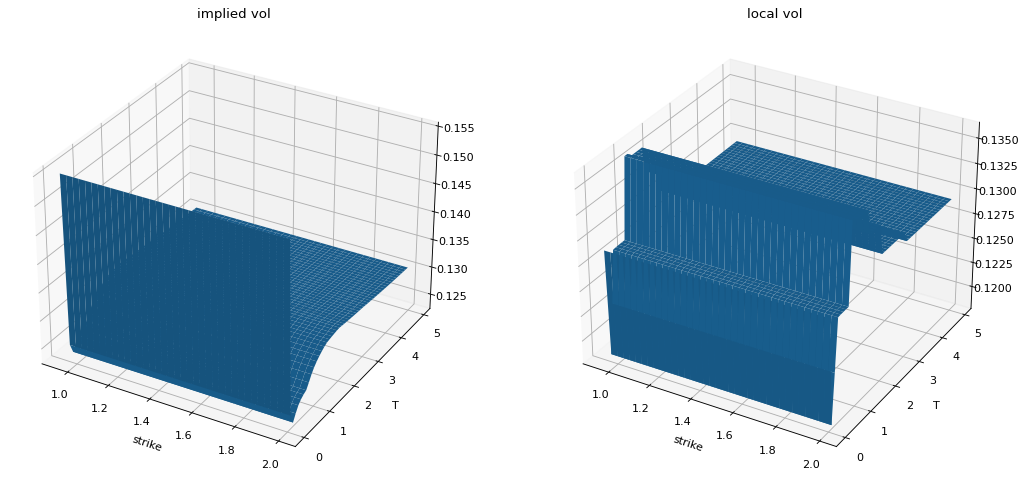

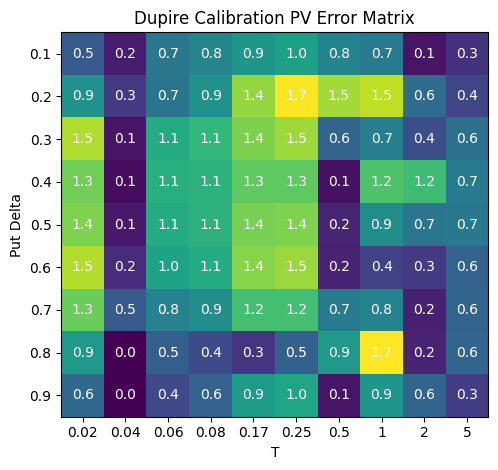

Time taken for 'Total Calibration Report': 27.0759 seconds


In [4]:
S, r, q = 1.25805, 0.01, 0.0
iv = createTestImpliedVol(S, r, q, sc = 0.0, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(S, r, q, iv)
pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a mild smile (tuned by the coeffiicent sc)

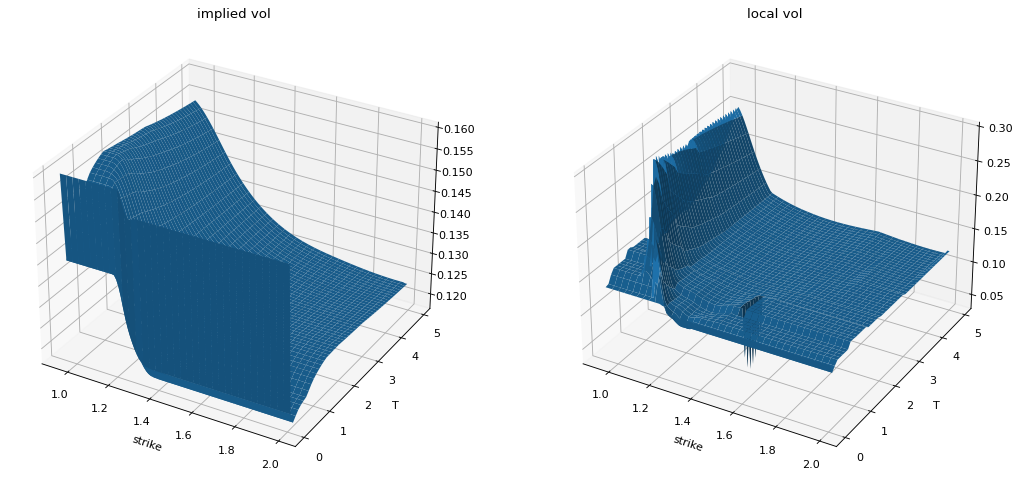

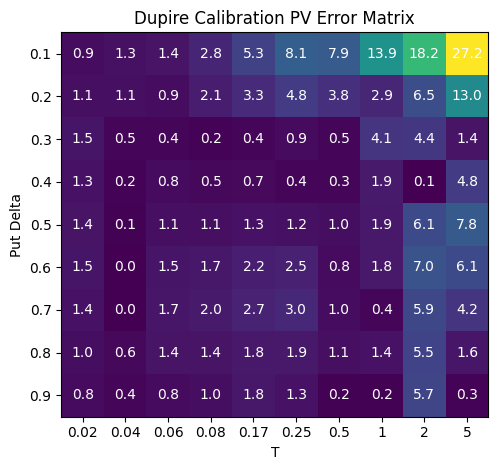

Time taken for 'Total Calibration Report': 22.6088 seconds


In [5]:
iv = createTestImpliedVol(S, r, q, sc = 0.5, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(S, r, q, iv)
pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a the input smile (sc = 1.0). It can be seen that the short end low strike region has some smile arbitrage. The calibration errors become larger.

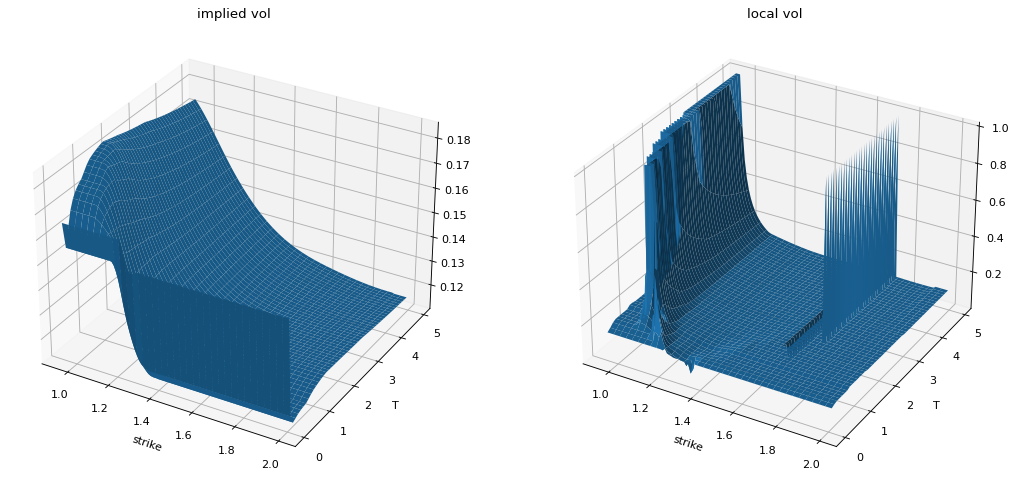

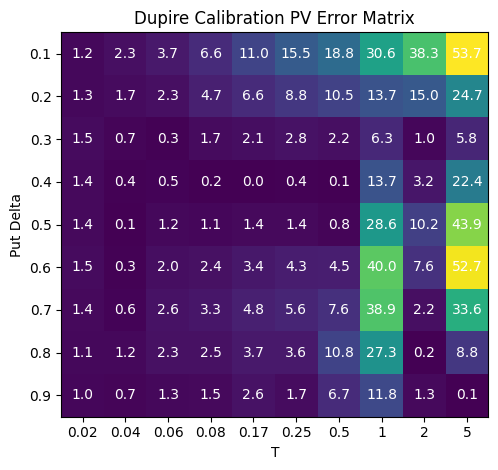

Time taken for 'Total Calibration Report': 22.4605 seconds


In [6]:
iv = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(S, r, q, iv)
pdeCalibReport(S, r, q, iv)

***
### Your test cases with SmileAF

     pcost       dcost       gap    pres   dres
 0:  5.7198e-02 -1.0808e+03  4e+03  2e+01  1e+02
 1:  5.7906e-02 -1.6949e+02  3e+02  1e+00  7e+00
 2:  5.9554e-02 -2.3830e+01  3e+01  1e-02  7e-02
 3:  5.9566e-02 -5.5094e-01  6e-01  3e-04  1e-03
 4:  5.9524e-02 -1.2177e-01  2e-01  6e-05  3e-04
 5:  5.9077e-02  3.3330e-02  3e-02  8e-06  5e-05
 6:  5.8502e-02  5.4875e-02  4e-03  9e-07  5e-06
 7:  5.8164e-02  5.7556e-02  6e-04  1e-07  6e-07
 8:  5.8034e-02  5.7915e-02  1e-04  1e-08  8e-08
 9:  5.7995e-02  5.7982e-02  1e-05  1e-09  7e-09
10:  5.7989e-02  5.7989e-02  3e-07  2e-11  9e-11
11:  5.7989e-02  5.7989e-02  4e-09  2e-13  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.7489e-02 -7.1118e+02  3e+03  2e+01  9e+01
 1:  5.8115e-02 -1.1489e+02  2e+02  1e+00  5e+00
 2:  5.9474e-02 -1.3517e+01  1e+01  1e-02  5e-02
 3:  5.9460e-02 -4.8890e-01  6e-01  4e-04  2e-03
 4:  6.0231e-02 -1.4070e-01  2e-01  7e-05  3e-04
 5:  5.9925e-02  3.6837e-02  2e-02  7e-06  4e-0

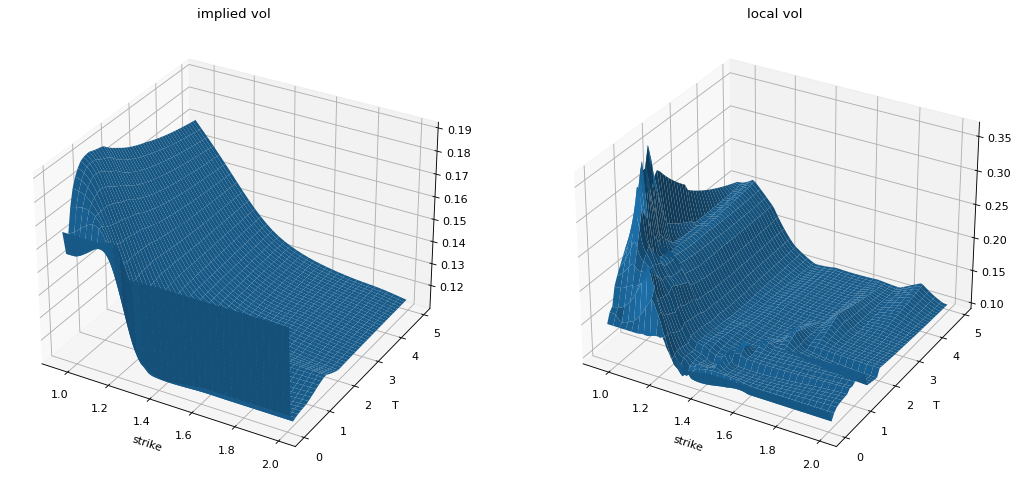

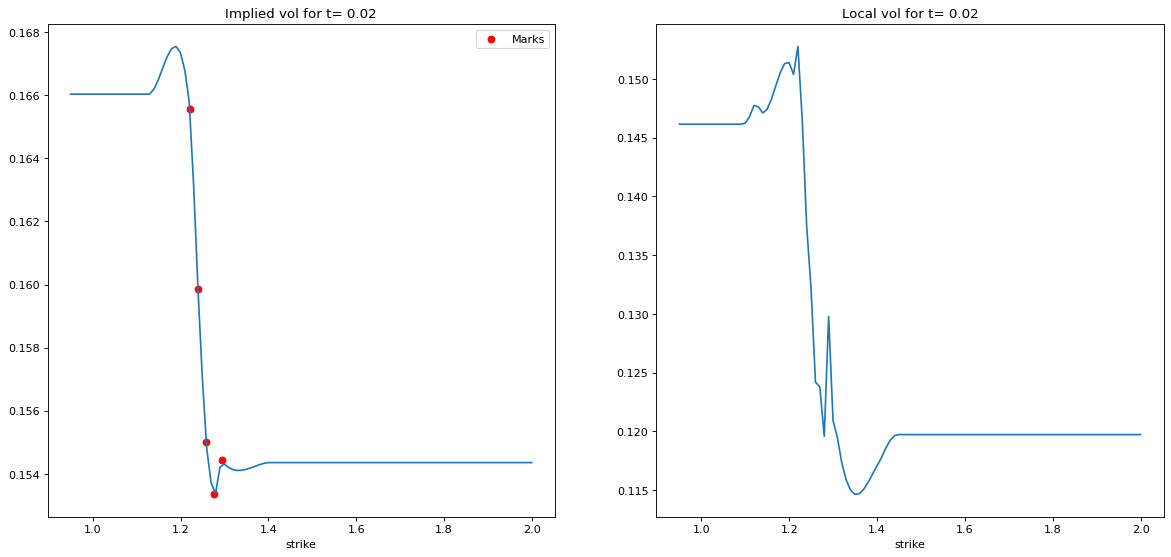

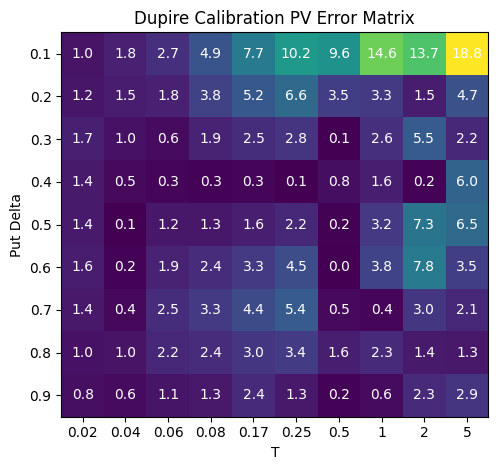

Time taken for 'Total Calibration Report': 46.5588 seconds
Time taken for 'Local Vol Surface Creation': 9.1189 seconds


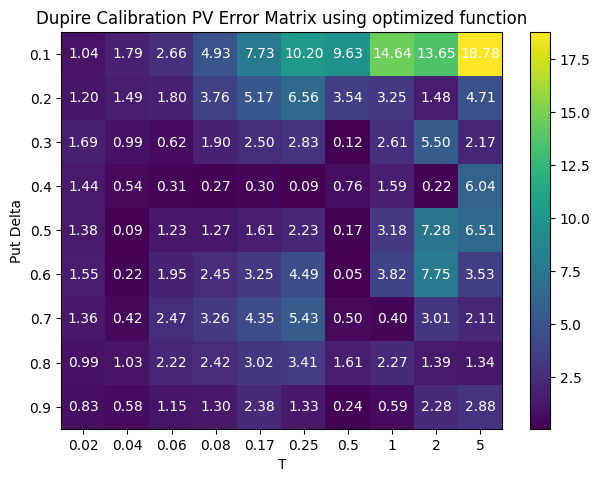

Time taken for 'Total Calibration Report': 9.3297 seconds


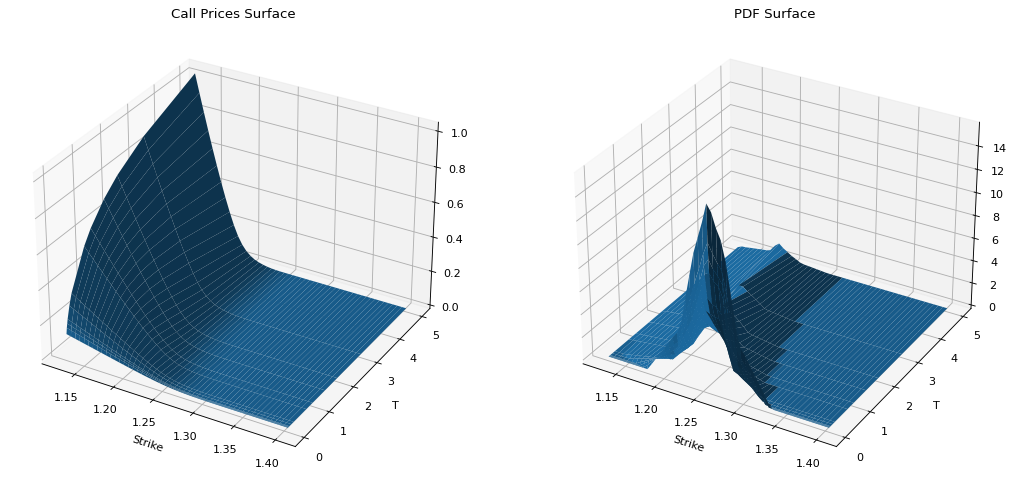

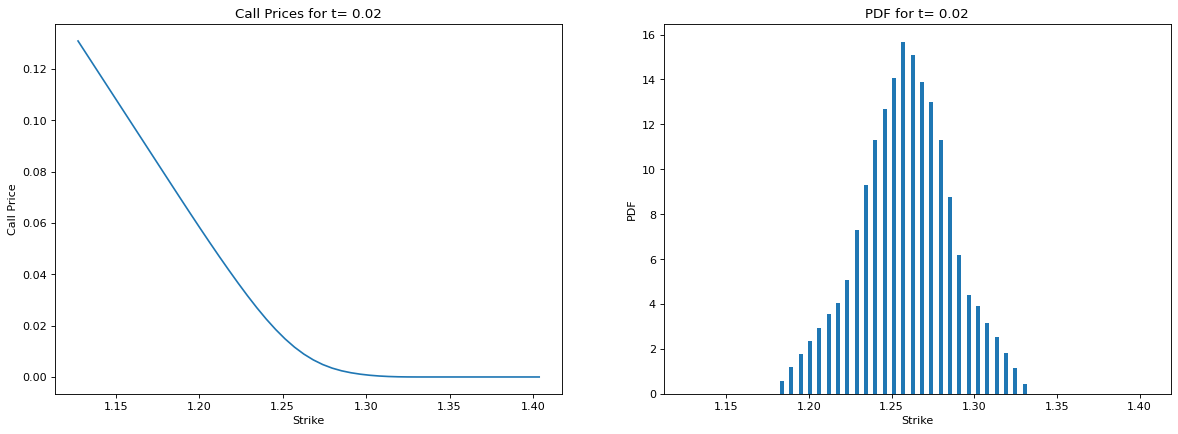

Sum of PDF = 1.0000000000000002


In [7]:
iv = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='AF')
plotTestImpliedVolSurface(S, r, q, iv)
plotTestImpliedVolSmile(S, r, q, iv,0.02)
pdeCalibReport(S, r, q, iv)
pdeCalibReport_New2(S, r, q, iv)
plotTestAFCallPrices_PDF(iv)
plotTestAFCallPrices_PDF_Single(iv,0.02)

<a id="project-report"></a>

# PROJECT REPORT

<a id="section-1"></a>

## 1. Notes on the results shown above

- Above we Implemented an arbitrage free smile interpolator SmileAF.
- Then used the arbitrage free smile interpolator to construct local volatility model
- Then we use PDE with local volatility model to price the given set of European options (strike in delta  ×  maturity)

<a id="section-2"></a>

## 2. Comparison of Price Errors

### 2.1)  Below is a Comparison the price errors of arbitrage-free smile interpolator and the cubic spline smile interpolator:

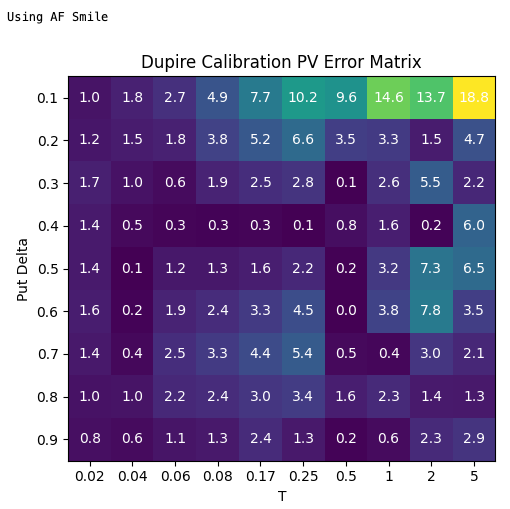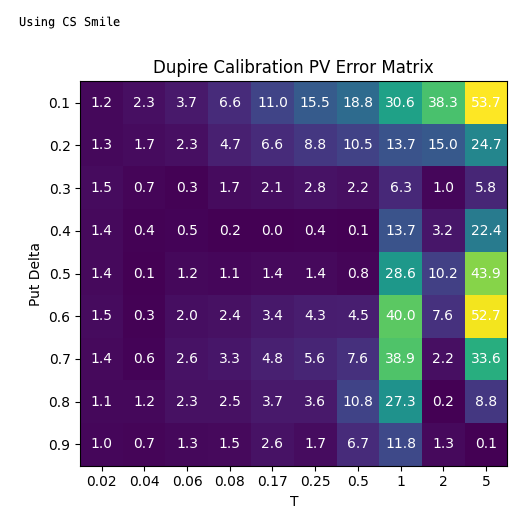

As can be seen, the PV Error has significantly reduced when using Arbitrage Free smile interpolator.

- The AF Smile interpolator shows overall lower pricing errors, indicating better model accuracy and adherence to arbitrage-free conditions compared to the CS Smile interpolator.
- Errors using CS Smile increase significantly with longer maturities, suggesting instability or poor extrapolation in the model for long-dated options.
- CS Smile exhibits a less uniform pattern of errors, indicating model deficiencies.
- The AF Smile's stability across various maturities suggests effective management of volatility term structure.
- Differences in heatmaps underscore the importance of robust model assumptions and the superiority of the AF Smile in maintaining arbitrage-free conditions.

### 2.2) Price Errors using same baseline

As the PV Error in the above matrix uses the Black scholes price as base using there corresponding Implied Vols i.e. Cubic Spline IV when comparing for Cubic Spline case and AF IV when comparing for Arbitrage Free,  we re-compared the CS and AF PDE Prices using Local Vol but using the same Black scholes prices based on Cubic Spline  IV. The intention was to keep the baseline as the same and see if the errors still reduced.

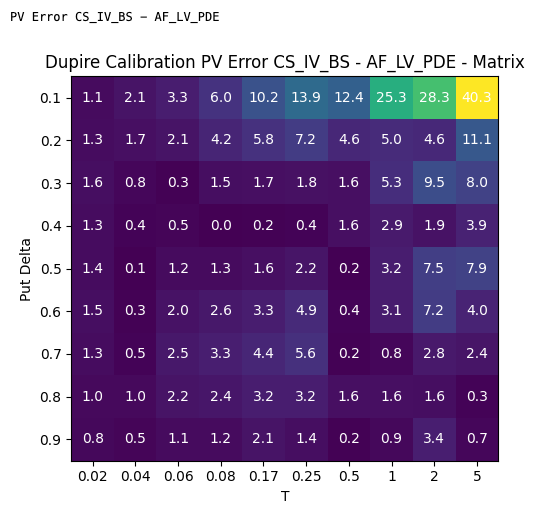 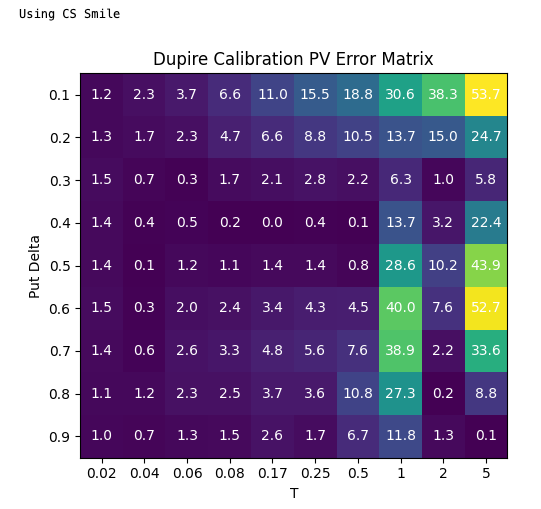

We still see improvement in the Pricing Error across Strikes and Time. The improvement is not as huge as before as the baseline when comparing Aribtrage Free case i.e. Price using Blacksholes and AF IV have moved as well.

The results above can be reproduced using pdeCalibReport_AFvsCS(S0, r, q, impliedVolAF, impliedVolCS) function defined above by inputting both AF and CS IV to it.

<a id="section-3"></a>

## 3. Verification of Result

### 3.1 Call Prices Smoothness
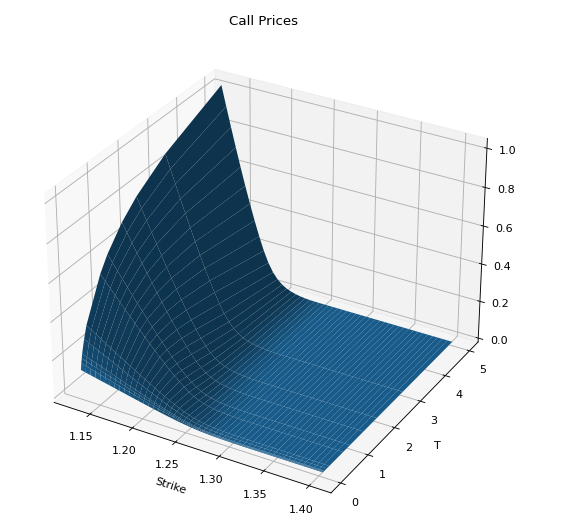

We can see above that the call prices are smooth across strikes and time

### 3.2 PDF Plot
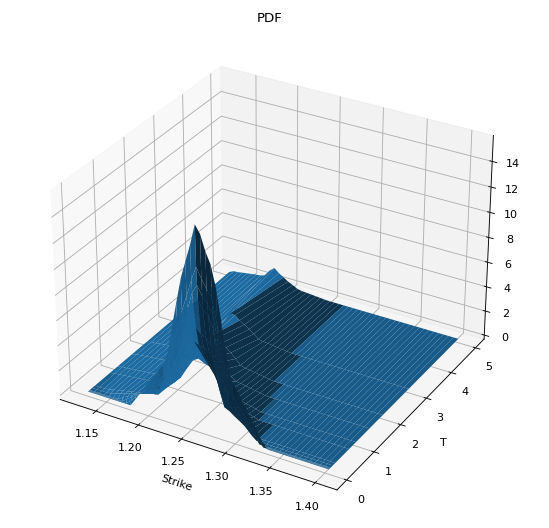

### 3.3 Vol Smile for a time slice and Marks Check
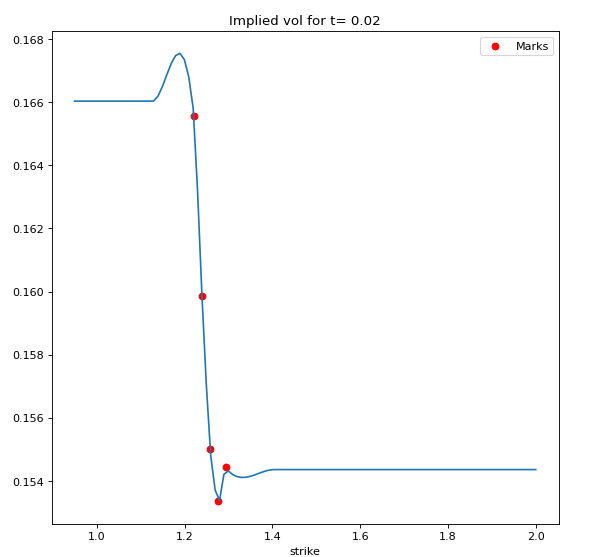

#### Remarks: The Implied Vol Smile using t=0.02 shows that Marks closely fall on it.

### 3.4 Call Prices for a time slice
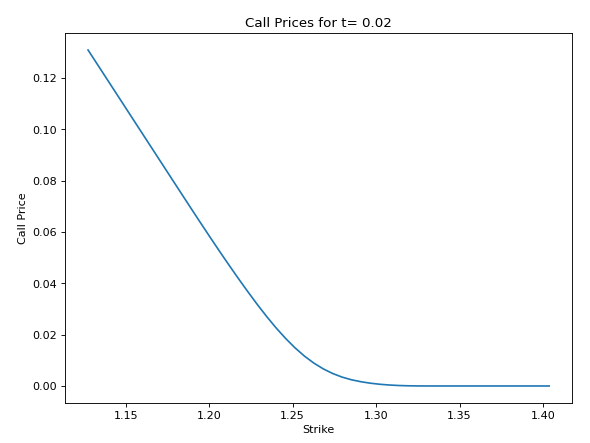

#### Remarks: Call Price is indeed monotonically decreasing

### 3.5 PDF for a time slice

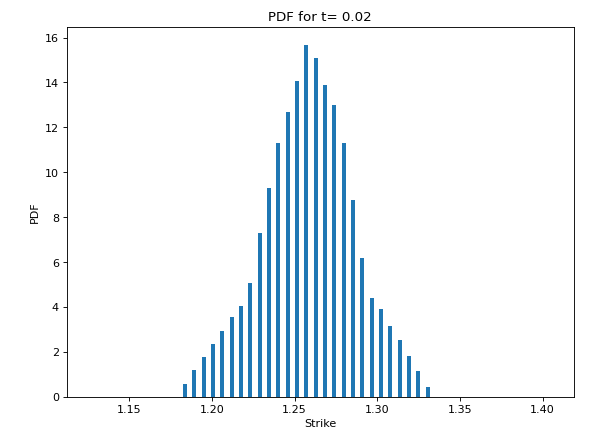
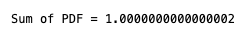

#### Remarks: PDF does have a Normal looking distribution with slightly fat tails. Also all PDF are positive and they  closely sum to one.

#### Overall Remark: All the sub points under #3 here verifies that our Implied Vol fitting under the Arbitrage Free conditions is correct

<a id="section-4"></a>

### 4. Critical Analysis and Issues

#### 4.1) Fitting of Marks
Although we have added Marks to fall on the cubic spline of call prices while optimizing for Arbitrage free call prices and pdf, and from the IV plots, we see that it does fall on smile very closely but it is still possible for the marks to not exactly fall on the Implied Vol spline due to Numerical error. This can happen because when we generate the strike grid for our IV fitting, we do so by equally placing 50 strikes between 5 S.D. of FWD Price. This doesn't guarantee we will have a strike in the grid exactly on the 5 marks hence the need of an extra interpolation and possibility of a numerical error.

For example, for T=5, if we calculate the atm vol in the next cell using fwd as strike in the fitted smile, we get 0.13050027559333138 when the atm vol mark was 0.1305. 

We will try to address this in section 5 and see if we can bring the vols closer to marks.

In [8]:
print(f'atm vol calculated using fitted smile for t=5   : {iv.Vol(5, S * math.exp((r-q)*5))}')
print(f'atm vol marked from the market for t=5 was      : {0.1305}')

atm vol calculated using fitted smile for t=5   : 0.1304966891580852
atm vol marked from the market for t=5 was      : 0.1305


#### 4.2) Fitting in the Wings
First lets define the Wing more precisely. In our Implementation, it is the strike region between -5 stanrd deviation of fwd prices and 10 Put Delta for the left wing and it is the strike region between 5 stadard deviation of fwd prices and 10 Call Delta for the right wing.

The Region beyond 5 standard deviation, we can safely assume to have no pdf, as can also be seen in the PDF plots above.

Looking at the Implied Vol Smile fit for t=0.02, the wings are circled below. Also, 10 Delta Put and Call Strikes can be seen as the leftmost and rightmost red dot respectively. 
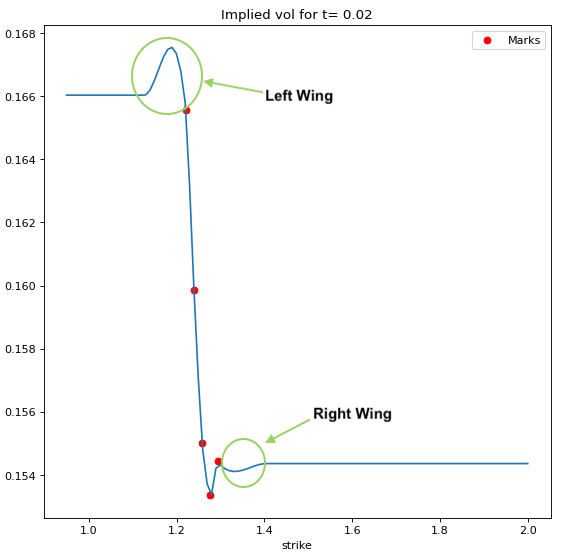

Below are our issues with this fitted smile in the wing:
1. The Implied vol is not really flat extrapolated in the wings if that was intended as a basic tail assumption of normality. We can see this in the plot above. This is because although we made the last two points to have the same value, the cubic spline fits a cubic function in between hence causing the hump.

2. The outer edge of the wings and the flat extrapolation beyond doesn't exactly match the 10 Delta Put/Call vol marks. This is because when we generate the strike grid for our IV fitting, we do so by equally placing 50 strikes between 5 S.D. of FWD Price. This doesn't guarantee we will have a strike in the grid at 10 delta and so we take the nearest strike on the outer side as a proxy of the 10 delta point for extrapolation purpose.

We will try to address these short comings in section 5.

### 4.3 Efficiency

We find it intriguing that the PDE Calibration report was taking more than a minute. We find this too high.

We will try to address this issue and reduce the time taken in section 5.3

<a id="section-5"></a>

## 5. Improvements

### 5.1) Fitting of Marks (Model and Precision Improvement)
To overcome the issue described in section 4.1 whereby the strike of the marks may not even fall on the strike grid hence causing numerical issue, we tried 2 solutions here:
1. Increase strike grid size from 50 to 51 and make the grid creation linear rather than exponential.This ensures that atleast the ATM fwd strike always falls exactly on the strike grid reducing numerical error around atm.

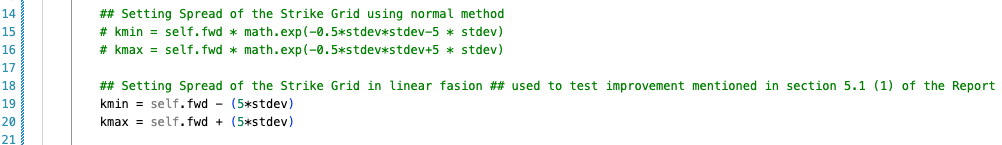

With the above change, we can achieve a much better fitter fit of the IV smile to market. See result after change below:

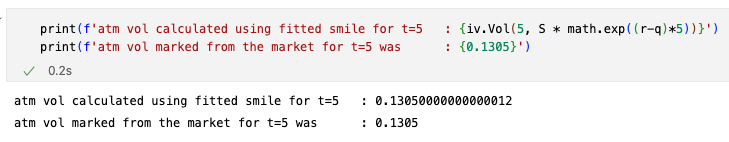

#### Remarks: The above vol is much close to the marks than what we observed before without matching ATM strike.

2. We also tried optimizing the strike grid so to minimize the sum of squared distance of the strike grid with the mark points. Below is the code within SmileAF constructor:

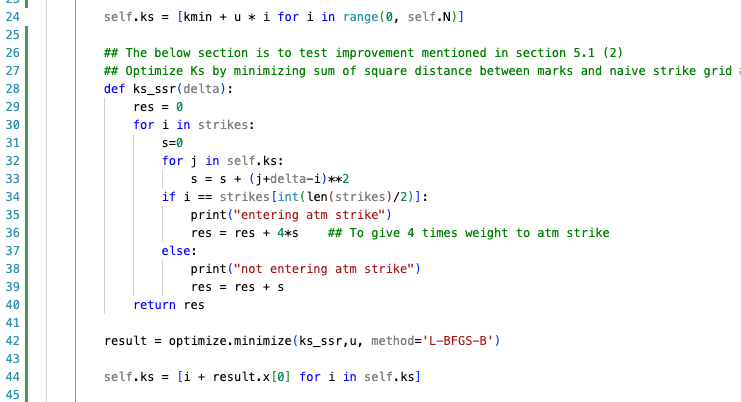

Below is the output of vol at atm fwd strike using the fitted smile:

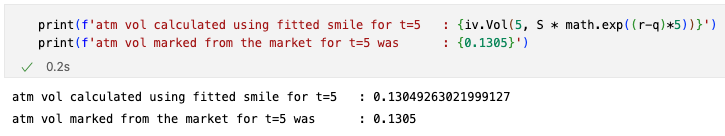

#### Remarks: The Outcome of this optimization was that it improved the Vol fitting to marks slightly but not as much as we observed after exactly matching atm fwd on the strike grid.

### 5.2) Fitting in the wings (model improvement)

Firstly, lets understand why the fitting in the wing is so difficult and we have to resort to approximations like flat vol. This happens because at wings, the Price to vol gradient is too low and is numerically not stable. Let me show this with some graphs:

The 4 graphs below are the plots of Price error (Option Price based on Vol - Call Price based on AF consitions) against all possible vols. We can clearly see that at extreme strikes (the "wings"), the plot of price error becomes asymptote to zero hence making any root search algorithm numerical unstable when used on it. The plot for in between strikes looks good and easy for the root search to work.

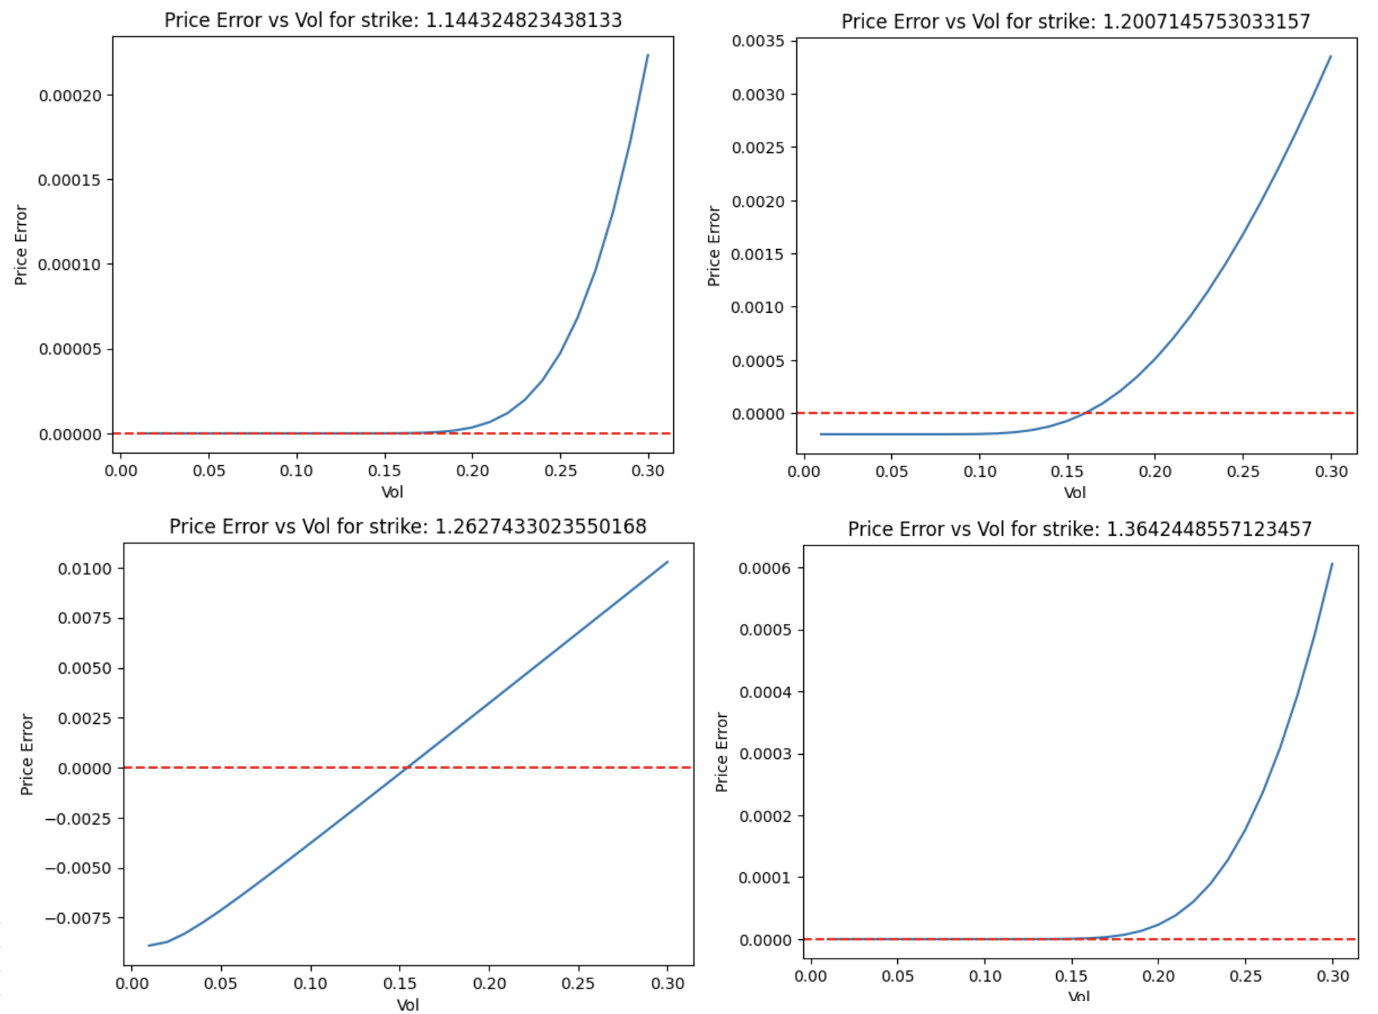

We also tried to find IV for each strike at wings and fit a cubic spline but root search failed as expected.

### 5.2.1) Flat Vol

The first solution we will try on the wings is a flat vol which seems to be an assumption in this project but the result doesn't align so we will fir a flat vol first and check how our Vol surface looks. Below is the implementation done in SmileAF constructor

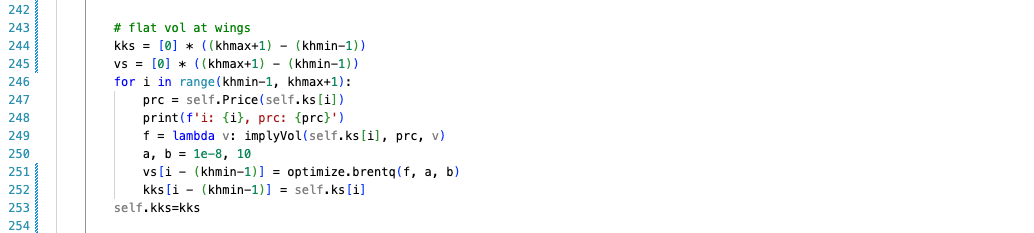

Flat extrapolation also needs to be updated from 10 delta put and call points with SmileAF.Vol function
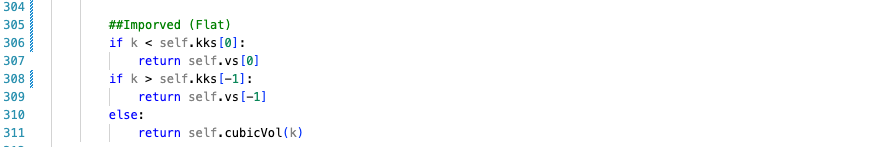

The new vol surface looks like below:
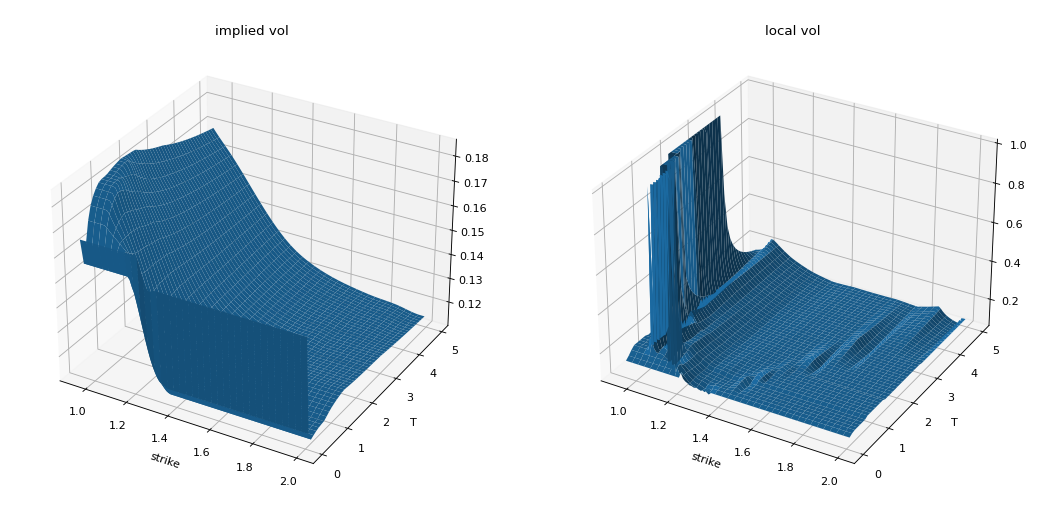

For a time slice, t=0.02, the vol smile looks like below:

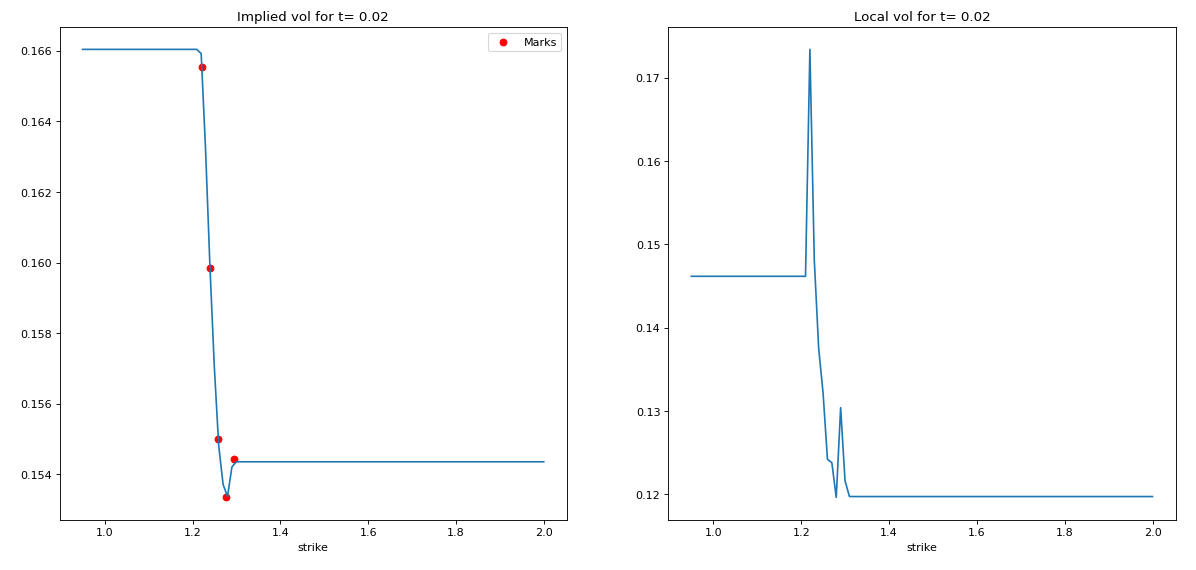

The Price Errors have obviously detoriated as this is the base case assumptions.

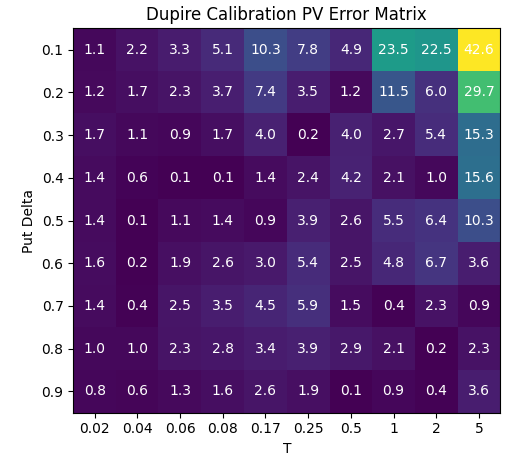

### 5.2.2) Linear Vol
Lets see if we can do any better. Since it would be too aggresive to linear interpolate on the whole wing, we instead decided to interpolate linearly on half of the wing and leave the rest half of the wing flat. Below is the implementation in SmileAF.vol function:

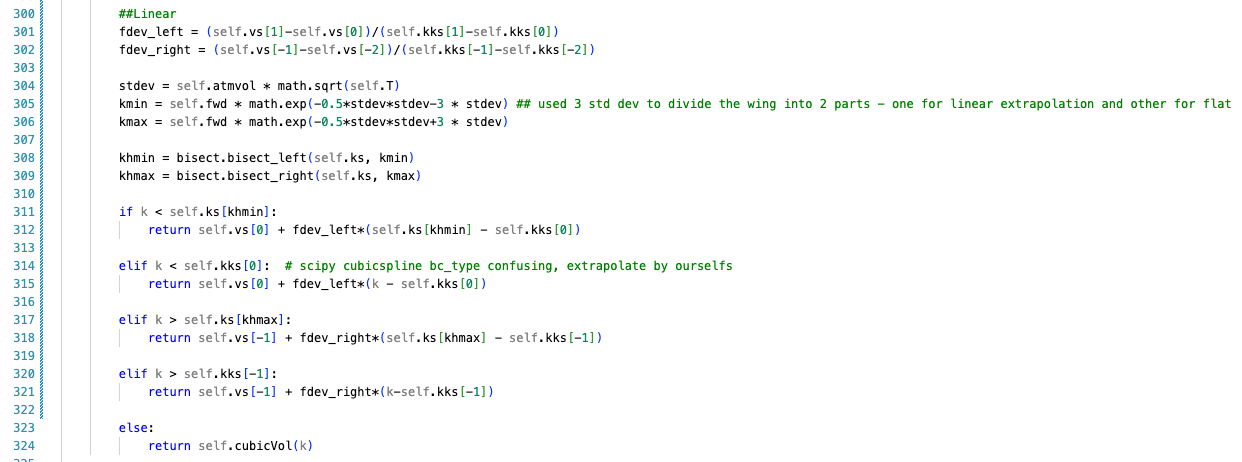

We also changed the cubic spline boundary condition in this case to have 2nd derivative zero instead of first so the linear interpolation is not flat.

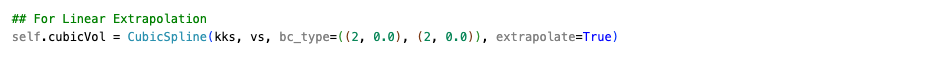

Below are the fitted vols surface using this method:
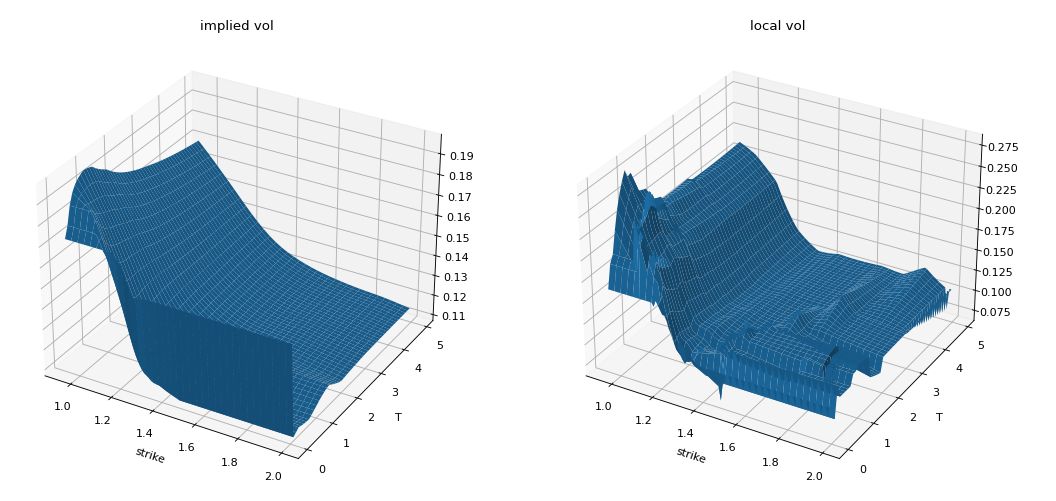

Below is a time slice of the vol surface for t=0.02:

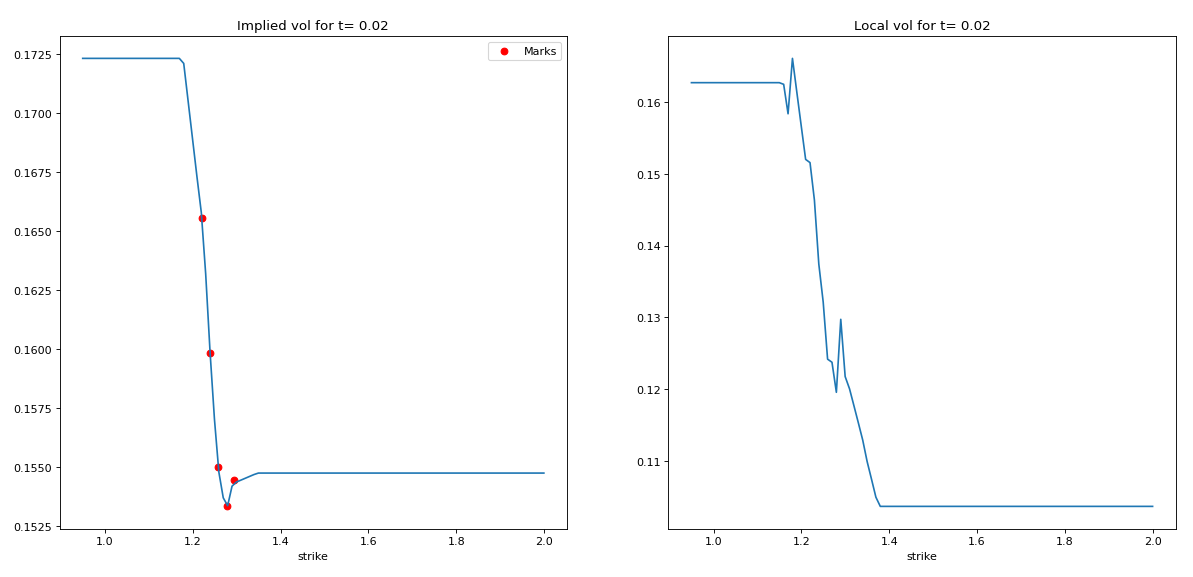

And below are the Price errors. We can see an impressive decreasing in the pricing errors.

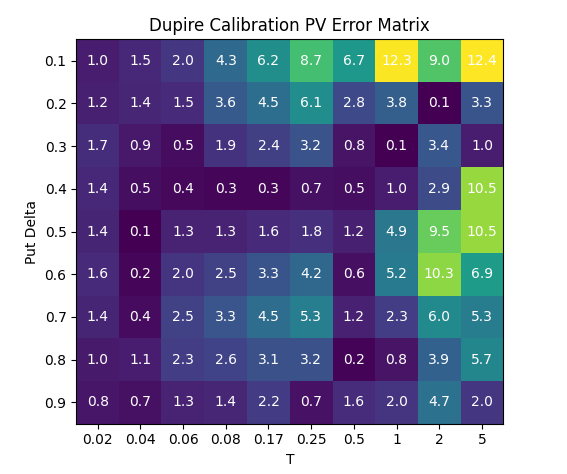

#### Remarks: The results are promising with linear interpolation in the wing upto 3 std dev and flat after that. The price errors has significantly reduced as well.

### 5.2.3) fitting tail to a distribution:

We also tried a 3rd method whereby we fit the tail to a known distribution parameterically. As per a research paper we read as part of the literature review, it had indicated to use GEV (Generalised Extreme Value Distribution). We were able to fit the distribution on the tail but due to lack of time, were not able to proceed further. We will put this as an area of future improvement for our submission.

### 5.3) Efficiency of the PDE Calibration Report function

We managed to reduce the Time of running this function from 62 sec to 10.5 sec. We achieve this by:

1) Parallelization: The loop over i and j is parallelized using joblib library, which can significantly speed up the computation if you have multiple CPU cores available.
2) Function Calls: The computations within the loop are now encapsulated within a function, compute_error, which reduces redundant function calls.
3) Vectorization: Instead of filling the error matrix in nested loops, a flattened list of errors is computed in parallel and reshaped to form the error matrix.

The new function is available as pdeCalibReport_New2 and the result from this function is provided below:

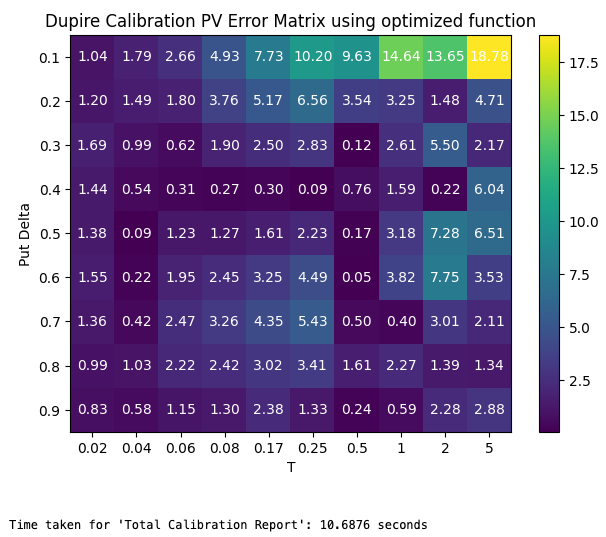



The original function took around 62 seconds:

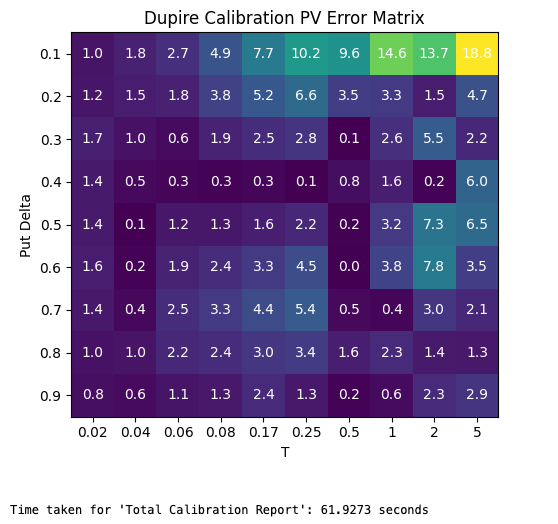

<a id="section-6"></a>

## 6. Conclusion and Next Steps

#### In Summary, Our Achievements were as below:
1. We were able to create an Arbitrage free vol smile and then create a Local Vol surface and use it along with PDE pricer to price multiple European Option. 
<br>

2. We generated the PV Error Matrix and studied the comparison of PV error against that of cubic spline. In addition, we have also shown how the comparison after using Black scholes price from cubic spline IV as baseline in both cases.
<br>

3. For verification of the fitted smile,
    - We verified call price smoothness of the Aribtrage free smile.
    - We did the PDF surface plot to check for negative PDFs. 
    - We went on to inspect a time slice of vol surface to check if the Marks fell on the fitted vol.
    - We checked a time slice of a call price to verify that it is monotonically decreasing.
<br>

4. We performed critical analysis and outlined areas of improvement in the model as well precision and efficiency. Areas of improvement were:
    - Small Error due to Strike grid not matching strike marks.
    - tail was fitted by cubic spline with both ends set to the same value. This can introduce arbitrage.
    - Efficiency of PDE Calibration report was not great.

<br>

5. We made below improvements to make it a better:
    - We reduced the small error in the fitted vol due to Strike grid not falling on strike marks, by  2 methods:
        - 1st was by  fixing the centre strike in the grid to the forward atm strike. 
        - 2nd was by running a minimization on the sum of squared errors of the distance between each point in the strike grid and strike marks. This also made our result more precise as less interpolation was needed.
    - We modelled the tail using 2 methods:
        - first method was to improve the current flat vol extrapolation where only 2 end points were flat and the middle portion was fitted using cubic spline. We were succefully able to achieve the results but we concluded that flat vol is not a great method to do this.
        - second, we created our own model for the wings i.e. using linear extrapolation until half of the wing then followed by flat extrapolation. This method gave us great results.
    - We were able to achieve efficiency improvement on the PDE Calibration Report generation function by using vectorization. We reduced the time taken from 62 seconds earlier to around 10.5 seconds.

<br>

6. We have created the below new functions apart from the several modifications to the existing functions to acheive the above:
    - def plotTestImpliedVolSmile(S, r, q, iv, t)
    - def plotTestAFCallPrices_PDF(iv):
    - def plotTestAFCallPrices_PDF_Single(iv, t):
    - def pdeCalibReport_AFvsCS(S0, r, q, impliedVolAF, impliedVolCS):
    - def pdeCalibReport_New2(S0, r, q, impliedVol):
    - def time_block_start():
    - def time_block_end(start, description):

<br>

Our code is also available in this github repository - https://github.com/agarwgou/QF607_Project. Project_Test.ipynb in this repo has all the test cases and results in it and source folder has all the class and functions defined.


Thank you.